In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime
from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import nltk
from nltk.corpus import stopwords
import re
import pickle
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
%matplotlib inline
plt.style.use('ggplot')

In [2]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')          
stopWords = list(stopwords.words('english'))   

def is_stock_up(row):
    return True if row[1] < row[4] else False


def tokenize_paragraph(paragraph):
    raw_sentences = tokenizer.tokenize(paragraph)
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(sentence_to_wordlist(raw_sentence.lower()))
    return sentences
            
        
def remove_stopwords(sentences):
    sent_remove_stopwords = []
    for sent in sentences:
        append_sent = []
        for word in sent:
            if word not in stopWords:
                append_sent.append(word)
        sent_remove_stopwords.append(append_sent)
    return sent_remove_stopwords
        
            
def clean_text(paragraph):
    sentences = tokenize_paragraph(paragraph)
    sent_remove_stopwords = remove_stopwords(sentences)
    words = []
    for sent in sent_remove_stopwords:
        for word in sent:
            words.append(word)
    return words

#check gensim
def get_paragraph_vectors(tokens): 
    num_tokens = len(tokens)
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(tokens)]
    global doc2vec
    doc2vec = pickle.load(open('doc2vec.sav', 'rb'))
    return [doc2vec.dv[i] for i in range(num_tokens)]

#check gensim
def get_infered_vectors(tokens):
    return model.infer_vector(tokens)
       
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

def reduce_dimensions(vectors):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # reduce using t-SNE
    print('transforming to vectors...')
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=42)
    print('applying tsne...')
    vectors = tsne.fit_transform(vectors)
    print('appending to list...')
    X = [v[0] for v in vectors]
    y = [v[1] for v in vectors]
    return X, y

def get_numpy_array(pandas_series, num_features=300):
    zeroes = np.empty((len(pandas_series),num_features))
    i = 0
    for vectors in pandas_series:
        zeroes[i] = np.array(vectors)
        i+=1
    return zeroes

def get_autoencoder_result(numpy_array):
    encoded_text = encoder.predict(numpy_array)
    return decoder.predict(encoded_text)

def get_vector_difference(initial_vector, decoded_vector):
    return np.absolute(initial_vector.sum() - decoded_vector.sum())

#check gensim
def get_word_vectors(model):
    vectors = [] # positions in vector space
    labels = [] # keep track of words to label our data again later
    for word in model.wv.key_to_index:
        vectors.append(model.wv[word])
        labels.append(word)
    return vectors, labels

def get_date(dt_series,premarket_movement=True):
    years = dt_series.dt.year
    months = dt_series.dt.month
    days = dt_series.dt.day
    dates = []
    for year, month, day in zip(years,months,days):
        if premarket_movement:
            date_string = '{day}-{month}-{year}'.format(day=day+1,month=month,year=year)
        else:
            date_string = '{day}-{month}-{year}'.format(day=day,month=month,year=year)
        dates.append(date_string)
    return dates

def get_day_of_week(dt_series,shift_days=False):
    
    day_of_week = list(dt_series.dt.day_name())
    if shift_days:
        days_mapping={
            'Sunday':'Monday',
            'Monday':'Tuesday',
            'Tuesday':'Wednesday',
            'Wednesday':'Thursday',
            'Thursday':'Friday'
        }
        for i in range(len(day_of_week)):
            real_day = days_mapping[day_of_week[i]]
            day_of_week[i] = days_mapping[day_of_week[i]]
    
    return day_of_week
        
    

In [3]:
df = pd.read_csv('cleaned_wsb_sample.csv')

In [4]:
df['tokens'] = df.body.apply(clean_text)
df.head()

Unnamed: 0  Unnamed: 0.1  \
0      236247       9255158   
1      360612      19349227   
2     1073594      21554834   
3     1075236      21556706   
4      626534      19758583   

                                                body          created_utc  \
0  If a creditor holds convertible notes, sure. T...  2021-01-29 11:04:33   
1                                 You tried cash app  2021-01-30 23:44:26   
2  Yes I'm basing it off of financhill which was ...  2021-01-31 15:42:23   
3                         Love this, let’s moon!!! 🚀  2021-01-31 16:13:50   
4                  Why would you close it? It’s free  2021-02-12 19:10:25   

   is_submitter                                             tokens  
0         False  [creditor, holds, convertible, notes, sure, ha...  
1         False                                 [tried, cash, app]  
2         False  [yes, basing, financhill, updated, yesterday, ...  
3          True                                  [love, let, moon]  
4         False                               [would, close, free]

In [5]:
df = df.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)
df.head()

body          created_utc  \
0  If a creditor holds convertible notes, sure. T...  2021-01-29 11:04:33   
1                                 You tried cash app  2021-01-30 23:44:26   
2  Yes I'm basing it off of financhill which was ...  2021-01-31 15:42:23   
3                         Love this, let’s moon!!! 🚀  2021-01-31 16:13:50   
4                  Why would you close it? It’s free  2021-02-12 19:10:25   

   is_submitter                                             tokens  
0         False  [creditor, holds, convertible, notes, sure, ha...  
1         False                                 [tried, cash, app]  
2         False  [yes, basing, financhill, updated, yesterday, ...  
3          True                                  [love, let, moon]  
4         False                               [would, close, free]

In [7]:
df['length'] = df.tokens.apply(lambda x: len(x))

In [9]:
indicies = df[df.length <= 2].index
indicies

Int64Index([    8,    11,    20,    25,    26,    27,    33,    38,    40,
               42,
            ...
            65487, 65496, 65504, 65506, 65507, 65513, 65518, 65520, 65521,
            65528],
           dtype='int64', length=13737)

In [11]:
df = df.drop(indicies)
df

body          created_utc  \
0      If a creditor holds convertible notes, sure. T...  2021-01-29 11:04:33   
1                                     You tried cash app  2021-01-30 23:44:26   
2      Yes I'm basing it off of financhill which was ...  2021-01-31 15:42:23   
3                             Love this, let’s moon!!! 🚀  2021-01-31 16:13:50   
4                      Why would you close it? It’s free  2021-02-12 19:10:25   
...                                                  ...                  ...   
65526  Already opened up my TD account. Slowly moving...  2021-01-31 02:55:57   
65527               they are the absolute worst scammers  2021-01-29 23:25:44   
65529  Is there like a tutorial or idiots guide to op...  2021-01-31 13:33:59   
65530  IF HES STILL IN, IM STILL IN!\n\nWE HOLD THEY ...  2021-01-30 22:28:41   
65531  Fidelity investments an Old Broker and been ar...  2021-02-08 20:09:57   

       is_submitter                                             tokens  length  
0             False  [creditor, holds, convertible, notes, sure, ha...      31  
1             False                                 [tried, cash, app]       3  
2             False  [yes, basing, financhill, updated, yesterday, ...      13  
3              True                                  [love, let, moon]       3  
4             False                               [would, close, free]       3  
...             ...                                                ...     ...  
65526          True  [already, opened, td, account, slowly, moving,...       7  
65527         False                        [absolute, worst, scammers]       3  
65529         False  [like, tutorial, idiots, guide, opening, fidel...       7  
65530         False  [hes, still, im, still, hold, fold, aint, sell...      13  
65531         False  [fidelity, investments, old, broker, around, l...      17  

[51795 rows x 5 columns]

In [12]:
model = pickle.load(open('doc2vec.sav', 'rb'))
vectors = [model.infer_vector(text) for text in df.tokens]

In [13]:
df['vectors'] = vectors

In [14]:
vectors = np.array(vectors).reshape(len(vectors),len(vectors[0]))

In [15]:
neighbors = NearestNeighbors(n_neighbors=3, n_jobs=10)
print('Fitting...')
neighbors_fit = neighbors.fit(vectors)
print('Finding K Neighbors...')
distances, indices = neighbors_fit.kneighbors(vectors)
print('Sorting...')
distances = np.sort(distances, axis=0)
print('Getting 2nd column...')
distances = distances[:,1]

Fitting...
Finding K Neighbors...
Sorting...
Getting 2nd column...


Text(0.5, 0, 'Number of samples')

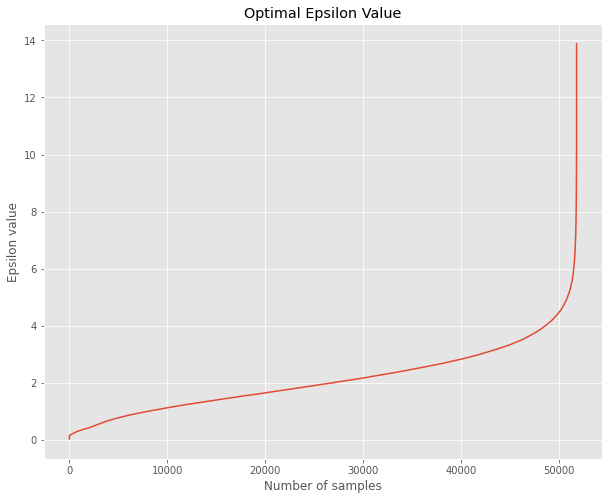

In [16]:
plt.figure(figsize=(10,8))
plt.plot(distances)
plt.title('Optimal Epsilon Value')
plt.ylabel('Epsilon value')
plt.xlabel('Number of samples')

In [17]:
dbscan = DBSCAN(eps=5,min_samples=3,n_jobs=10)

In [18]:
labels = dbscan.fit_predict(vectors)

In [19]:
df['labels'] = labels

In [20]:
df.labels.value_counts()

 0    50818
-1      959
 4        6
 1        3
 2        3
 3        3
 5        3
Name: labels, dtype: int64

In [31]:
df[df.labels==0]

body          created_utc  \
0      If a creditor holds convertible notes, sure. T...  2021-01-29 11:04:33   
1                                     You tried cash app  2021-01-30 23:44:26   
2      Yes I'm basing it off of financhill which was ...  2021-01-31 15:42:23   
3                             Love this, let’s moon!!! 🚀  2021-01-31 16:13:50   
4                      Why would you close it? It’s free  2021-02-12 19:10:25   
...                                                  ...                  ...   
65526  Already opened up my TD account. Slowly moving...  2021-01-31 02:55:57   
65527               they are the absolute worst scammers  2021-01-29 23:25:44   
65529  Is there like a tutorial or idiots guide to op...  2021-01-31 13:33:59   
65530  IF HES STILL IN, IM STILL IN!\n\nWE HOLD THEY ...  2021-01-30 22:28:41   
65531  Fidelity investments an Old Broker and been ar...  2021-02-08 20:09:57   

       is_submitter                                             tokens  \
0             False  [creditor, holds, convertible, notes, sure, ha...   
1             False                                 [tried, cash, app]   
2             False  [yes, basing, financhill, updated, yesterday, ...   
3              True                                  [love, let, moon]   
4             False                               [would, close, free]   
...             ...                                                ...   
65526          True  [already, opened, td, account, slowly, moving,...   
65527         False                        [absolute, worst, scammers]   
65529         False  [like, tutorial, idiots, guide, opening, fidel...   
65530         False  [hes, still, im, still, hold, fold, aint, sell...   
65531         False  [fidelity, investments, old, broker, around, l...   

       length                                            vectors  labels  
0          31  [0.54033834, -0.78952885, 0.23671637, -0.15288...       0  
1           3  [0.048983086, 0.12624192, -0.16883567, -0.2454...       0  
2          13  [-0.29032812, -0.08848444, -0.12936623, 0.1833...       0  
3           3  [0.15806015, 0.26056403, -0.41831416, -0.44748...       0  
4           3  [-0.08262474, 0.05127596, 0.358053, -0.1618231...       0  
...       ...                                                ...     ...  
65526       7  [0.07798159, -0.07439395, -0.090999156, -0.303...       0  
65527       3  [0.03683925, 0.1814884, -0.16021281, -0.303349...       0  
65529       7  [0.27001223, -0.18958145, 0.3589885, 0.1612618...       0  
65530      13  [-0.35125476, -0.030558383, 0.03329689, 0.1961...       0  
65531      17  [-0.04401789, 0.54949284, -0.35721338, -0.8207...       0  

[50818 rows x 7 columns]

In [40]:
import en_core_web_md
nlp = en_core_web_md.load()

In [42]:
spacy_text_blob = SpacyTextBlob()
nlp.add_pipe(spacy_text_blob)

In [48]:
text = ['absolute','worst','scammers']
text = ' '.join(text)
print(text)
doc = nlp(text)
doc._.sentiment.polarity      # Polarity: -0.125
#doc._.sentiment.subjectivity  # Sujectivity: 0.9
#doc._.sentiment.assessments

absolute worst scammers


-0.4

In [49]:
def get_sentiment(body):
    doc = nlp(body)
    return doc._.sentiment.polarity

def get_subjectivity(body):
    doc = nlp(body)
    return doc._.sentiment.subjectivity
    

In [50]:
df['sentiment'] = df.body.apply(get_sentiment)

In [51]:
df['subjectivity'] = df.body.apply(get_subjectivity)

In [52]:
df.created_utc = pd.DatetimeIndex(data=df.created_utc,tz='Etc/Universal')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51795 entries, 0 to 65531
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype                        
---  ------        --------------  -----                        
 0   body          51795 non-null  object                       
 1   created_utc   51795 non-null  datetime64[ns, Etc/Universal]
 2   is_submitter  51795 non-null  bool                         
 3   tokens        51795 non-null  object                       
 4   length        51795 non-null  int64                        
 5   vectors       51795 non-null  object                       
 6   labels        51795 non-null  int64                        
 7   sentiment     51795 non-null  float64                      
 8   subjectivity  51795 non-null  float64                      
dtypes: bool(1), datetime64[ns, Etc/Universal](1), float64(2), int64(2), object(3)
memory usage: 3.6+ MB


In [183]:
stocks = ['GME.csv','BB.csv','AMC.csv','NOK.csv','PLTR.csv','TSLA.csv']
df_stocks = []
for stock in stocks:
    df_stocks.append(pd.read_csv(stock))
    
filtered_stocks = []
for frame in df_stocks:
    frame.Date = pd.DatetimeIndex(data=frame.Date)
    filtered_stocks.append(frame[frame.Date >= datetime(2020, 12, 25)])
    
df_stocks = []
for frame in filtered_stocks:
    frame.Date = pd.DatetimeIndex(data=frame.Date,tz='Etc/Universal')
    frame.Date = frame.Date.apply(lambda timestamp : timestamp.tz_convert('US/Eastern'))
    df_stocks.append(frame)
    
for frame in df_stocks:
    frame['up_today'] = frame.apply(is_stock_up,axis=1)

In [184]:
time_erase = df_stocks[0].iloc[3,0]
def rotate_df_series(movements):
    first_half = [movements[-1]]
    second_half = movements[:-1]
    first_half.extend(second_half)
    return first_half

def remove_first_row(df):
    row = df[df.Date<=time_erase].index
    return df.drop(row)

In [185]:
cleanned_frames = []
for frame in df_stocks:
    movements = list(frame.up_today)
    prev_day = rotate_df_series(movements)
    frame['up_prev_day'] = prev_day
    frame = remove_first_row(frame)
    cleanned_frames.append(frame)
df_stocks = []
for frame in cleanned_frames:
    frame = remove_first_row(frame)
    df_stocks.append(frame)

In [186]:
df_stocks[0]

Date        Open        High         Low  \
4755 2021-01-03 19:00:00-05:00   19.000000   19.100000   17.150000   
4756 2021-01-04 19:00:00-05:00   17.350000   18.080000   17.230000   
4757 2021-01-05 19:00:00-05:00   17.340000   18.980000   17.330000   
4758 2021-01-06 19:00:00-05:00   18.469999   19.450001   18.020000   
4759 2021-01-07 19:00:00-05:00   18.180000   18.299999   17.080000   
4760 2021-01-10 19:00:00-05:00   19.410000   20.650000   19.010000   
4761 2021-01-11 19:00:00-05:00   19.959999   20.400000   19.320000   
4762 2021-01-12 19:00:00-05:00   20.420000   38.650002   20.030001   
4763 2021-01-13 19:00:00-05:00   38.090000   43.060001   33.049999   
4764 2021-01-14 19:00:00-05:00   38.490002   40.750000   34.009998   
4765 2021-01-18 19:00:00-05:00   41.549999   45.520000   36.639999   
4766 2021-01-19 19:00:00-05:00   37.369999   41.189999   36.060001   
4767 2021-01-20 19:00:00-05:00   39.230000   44.750000   37.000000   
4768 2021-01-21 19:00:00-05:00   42.590000   76.760002   42.320000   
4769 2021-01-24 19:00:00-05:00   96.730003  159.179993   61.130001   
4770 2021-01-25 19:00:00-05:00   88.559998  150.000000   80.199997   
4771 2021-01-26 19:00:00-05:00  354.829987  380.000000  249.000000   
4772 2021-01-27 19:00:00-05:00  265.000000  483.000000  112.250000   
4773 2021-01-28 19:00:00-05:00  379.709991  413.980011  250.000000   
4774 2021-01-31 19:00:00-05:00  316.559998  322.000000  212.000000   
4775 2021-02-01 19:00:00-05:00  140.759995  158.000000   74.220001   
4776 2021-02-02 19:00:00-05:00  112.010002  113.400002   85.250000   
4777 2021-02-03 19:00:00-05:00   91.190002   91.500000   53.330002   
4778 2021-02-04 19:00:00-05:00   54.040001   95.000000   51.090000   
4779 2021-02-07 19:00:00-05:00   72.410004   72.660004   58.020000   
4780 2021-02-08 19:00:00-05:00   56.610001   57.000000   46.520000   
4781 2021-02-09 19:00:00-05:00   50.770000   62.830002   46.549999   
4782 2021-02-10 19:00:00-05:00   50.009998   55.320000   48.220001   
4783 2021-02-11 19:00:00-05:00   50.750000   55.240002   48.049999   
4784 2021-02-15 19:00:00-05:00   52.660000   53.500000   49.040001   
4785 2021-02-16 19:00:00-05:00   49.770000   51.189999   44.560001   
4786 2021-02-17 19:00:00-05:00   48.490002   48.869999   40.650002   
4787 2021-02-18 19:00:00-05:00   41.279999   43.889999   38.500000   
4788 2021-02-21 19:00:00-05:00   46.689999   48.509998   42.400002   
4789 2021-02-22 19:00:00-05:00   44.970001   46.230000   40.000000   
4790 2021-02-23 19:00:00-05:00   44.700001   91.709999   44.700001   
4791 2021-02-24 19:00:00-05:00  169.559998  184.679993  101.000000   
4792 2021-02-25 19:00:00-05:00  117.459999  142.899994   86.000000   
4793 2021-02-28 19:00:00-05:00  104.540001  133.990005   99.970001   
4794 2021-03-01 19:00:00-05:00  116.930000  133.199997  112.199997   
4795 2021-03-02 19:00:00-05:00  122.510002  127.750000  113.120003   
4796 2021-03-03 19:00:00-05:00  125.000000  147.869995  115.300003   
4797 2021-03-04 19:00:00-05:00  128.169998  151.529999  127.500000   
4798 2021-03-07 19:00:00-05:00  154.889999  210.869995  146.100006   
4799 2021-03-08 19:00:00-05:00  217.710007  249.850006  208.509995   
4800 2021-03-09 19:00:00-05:00  269.429993  348.500000  172.000000   
4801 2021-03-10 19:00:00-05:00  241.639999  281.500000  232.600006   
4802 2021-03-11 19:00:00-05:00  275.000000  295.500000  262.269989   
4803 2021-03-14 20:00:00-04:00  277.519989  283.000000  206.000000   
4804 2021-03-15 20:00:00-04:00  203.160004  220.699997  172.350006   
4805 2021-03-16 20:00:00-04:00  217.839996  231.470001  204.000000   
4806 2021-03-17 20:00:00-04:00  214.000000  218.880005  195.649994   
4807 2021-03-18 20:00:00-04:00  195.729996  227.000000  182.660004   
4808 2021-03-21 20:00:00-04:00  205.259995  210.360001  186.199997   
4809 2021-03-22 20:00:00-04:00  197.500000  201.750000  177.550003   
4810 2021-03-23 20:00:00-04:00  157.979996  166.970001  118.620003   
4811 2021-03-24 20:00:00-04:00  123.

In [188]:
df.head()

body  \
0  If a creditor holds convertible notes, sure. T...   
1                                 You tried cash app   
2  Yes I'm basing it off of financhill which was ...   
3                         Love this, let’s moon!!! 🚀   
4                  Why would you close it? It’s free   

                created_utc  is_submitter  \
0 2021-01-29 11:04:33+00:00         False   
1 2021-01-30 23:44:26+00:00         False   
2 2021-01-31 15:42:23+00:00         False   
3 2021-01-31 16:13:50+00:00          True   
4 2021-02-12 19:10:25+00:00         False   

                                              tokens  length  \
0  [creditor, holds, convertible, notes, sure, ha...      31   
1                                 [tried, cash, app]       3   
2  [yes, basing, financhill, updated, yesterday, ...      13   
3                                  [love, let, moon]       3   
4                               [would, close, free]       3   

                                             vectors  labels  sentiment  \
0  [0.54033834, -0.78952885, 0.23671637, -0.15288...       0   0.050000   
1  [0.048983086, 0.12624192, -0.16883567, -0.2454...       0   0.000000   
2  [-0.29032812, -0.08848444, -0.12936623, 0.1833...       0  -0.400000   
3  [0.15806015, 0.26056403, -0.41831416, -0.44748...       0   0.976562   
4  [-0.08262474, 0.05127596, 0.358053, -0.1618231...       0   0.400000   

   subjectivity  
0      0.448148  
1      0.000000  
2      0.633333  
3      0.600000  
4      0.800000

In [189]:
df['created_utc'] = df.created_utc.apply(lambda timestamp : timestamp.tz_convert('US/Eastern'))

In [192]:
df = df.sort_values('created_utc')

In [193]:
df.head()

body  \
23753   Did you honestly think that was done on purpose?   
44182  Yeah right. Man needed the hard truth &amp; I’...   
41509  Jokes on her your saving account is already empty   
25062  Have you seen him? Lame white hipster dude who...   
17847  This is our time bro. Crsr and psth can wait a...   

                    created_utc  is_submitter  \
23753 2020-12-31 19:30:47-05:00         False   
44182 2020-12-31 19:30:50-05:00         False   
41509 2020-12-31 19:31:59-05:00         False   
25062 2020-12-31 19:32:05-05:00         False   
17847 2020-12-31 20:16:57-05:00         False   

                                                  tokens  length  \
23753                   [honestly, think, done, purpose]       4   
44182  [yeah, right, man, needed, hard, truth, amp, t...      10   
41509           [jokes, saving, account, already, empty]       5   
25062  [seen, lame, white, hipster, dude, looks, like...      19   
17847  [time, bro, crsr, psth, wait, couple, weeks, g...      13   

                                                 vectors  labels  sentiment  \
23753  [-0.06739178, 0.038080487, -0.12307083, 0.0434...       0   0.600000   
44182  [0.33995894, 0.008714635, 0.35547084, 0.073937...       0  -0.002976   
41509  [0.32191882, 0.057902932, -0.2426322, 0.011836...       0  -0.100000   
25062  [-0.21993735, 0.020083344, -0.11642405, -0.435...       0  -0.008333   
17847  [0.20235, 0.049723938, -0.4092404, -0.43675855...       0   0.000000   

       subjectivity  
23753       0.90000  
44182       0.53869  
41509       0.50000  
25062       0.52500  
17847       0.00000

In [194]:
df.to_csv('wsb_sentiment.csv')

In [231]:
dates = get_date(df.created_utc, premarket_movement=False)
dates

['31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '31-12-2020',
 '1-1-2021',
 '1-1-2021',
 '1-1-2021',
 '1-1-2021',
 '1-1-2021',
 '1-1-2021',
 '1-1-2021',
 '1-1-2021',
 '1-1-2021',
 '1-1-2021',
 '1-1-2021',
 '1-1-2021',
 '1-1-2021',
 '1-1-2021',
 '1-1-2021',
 '1-1-2021',
 '1-1-2021',
 '1-1-2021',
 '1-1-2021',
 '1-1-2021',
 '1-1-2021',
 '1-1-2021',
 '1-1-2021',
 '1-1-2021',
 '1-1-2021',


In [214]:
df['date_strings'] = dates
df.head()

body  \
23753   Did you honestly think that was done on purpose?   
44182  Yeah right. Man needed the hard truth &amp; I’...   
41509  Jokes on her your saving account is already empty   
25062  Have you seen him? Lame white hipster dude who...   
17847  This is our time bro. Crsr and psth can wait a...   

                    created_utc  is_submitter  \
23753 2020-12-31 19:30:47-05:00         False   
44182 2020-12-31 19:30:50-05:00         False   
41509 2020-12-31 19:31:59-05:00         False   
25062 2020-12-31 19:32:05-05:00         False   
17847 2020-12-31 20:16:57-05:00         False   

                                                  tokens  length  \
23753                   [honestly, think, done, purpose]       4   
44182  [yeah, right, man, needed, hard, truth, amp, t...      10   
41509           [jokes, saving, account, already, empty]       5   
25062  [seen, lame, white, hipster, dude, looks, like...      19   
17847  [time, bro, crsr, psth, wait, couple, weeks, g...      13   

                                                 vectors  labels  sentiment  \
23753  [-0.06739178, 0.038080487, -0.12307083, 0.0434...       0   0.600000   
44182  [0.33995894, 0.008714635, 0.35547084, 0.073937...       0  -0.002976   
41509  [0.32191882, 0.057902932, -0.2426322, 0.011836...       0  -0.100000   
25062  [-0.21993735, 0.020083344, -0.11642405, -0.435...       0  -0.008333   
17847  [0.20235, 0.049723938, -0.4092404, -0.43675855...       0   0.000000   

       subjectivity date_strings  
23753       0.90000   31-12-2020  
44182       0.53869   31-12-2020  
41509       0.50000   31-12-2020  
25062       0.52500   31-12-2020  
17847       0.00000   31-12-2020

In [225]:
df['day_of_week'] = get_day_of_week(df.created_utc)
df.head()

body  \
23753   Did you honestly think that was done on purpose?   
44182  Yeah right. Man needed the hard truth &amp; I’...   
41509  Jokes on her your saving account is already empty   
25062  Have you seen him? Lame white hipster dude who...   
17847  This is our time bro. Crsr and psth can wait a...   

                    created_utc  is_submitter  \
23753 2020-12-31 19:30:47-05:00         False   
44182 2020-12-31 19:30:50-05:00         False   
41509 2020-12-31 19:31:59-05:00         False   
25062 2020-12-31 19:32:05-05:00         False   
17847 2020-12-31 20:16:57-05:00         False   

                                                  tokens  length  \
23753                   [honestly, think, done, purpose]       4   
44182  [yeah, right, man, needed, hard, truth, amp, t...      10   
41509           [jokes, saving, account, already, empty]       5   
25062  [seen, lame, white, hipster, dude, looks, like...      19   
17847  [time, bro, crsr, psth, wait, couple, weeks, g...      13   

                                                 vectors  labels  sentiment  \
23753  [-0.06739178, 0.038080487, -0.12307083, 0.0434...       0   0.600000   
44182  [0.33995894, 0.008714635, 0.35547084, 0.073937...       0  -0.002976   
41509  [0.32191882, 0.057902932, -0.2426322, 0.011836...       0  -0.100000   
25062  [-0.21993735, 0.020083344, -0.11642405, -0.435...       0  -0.008333   
17847  [0.20235, 0.049723938, -0.4092404, -0.43675855...       0   0.000000   

       subjectivity date_strings day_of_week  
23753       0.90000   31-12-2020    Thursday  
44182       0.53869   31-12-2020    Thursday  
41509       0.50000   31-12-2020    Thursday  
25062       0.52500   31-12-2020    Thursday  
17847       0.00000   31-12-2020    Thursday

In [229]:
df.day_of_week.value_counts()

Friday       13095
Saturday     10830
Sunday        9414
Monday        8308
Thursday      3735
Wednesday     3661
Tuesday       2752
Name: day_of_week, dtype: int64

In [242]:
df.groupby('day_of_week')['sentiment'].mean()

day_of_week
Friday       0.048035
Monday       0.050899
Saturday     0.055289
Sunday       0.055077
Thursday     0.063115
Tuesday      0.054841
Wednesday    0.056521
Name: sentiment, dtype: float64

In [244]:
df.to_csv('wsb_sentiment.csv')

In [240]:
for frame in df_stocks:
    dates = get_date(frame.Date)
    frame['date_strings'] = dates
    frame['day_of_week'] = get_day_of_week(frame.Date,shift_days=True)
    

In [241]:
df_stocks[0]

Date        Open        High         Low  \
4755 2021-01-03 19:00:00-05:00   19.000000   19.100000   17.150000   
4756 2021-01-04 19:00:00-05:00   17.350000   18.080000   17.230000   
4757 2021-01-05 19:00:00-05:00   17.340000   18.980000   17.330000   
4758 2021-01-06 19:00:00-05:00   18.469999   19.450001   18.020000   
4759 2021-01-07 19:00:00-05:00   18.180000   18.299999   17.080000   
4760 2021-01-10 19:00:00-05:00   19.410000   20.650000   19.010000   
4761 2021-01-11 19:00:00-05:00   19.959999   20.400000   19.320000   
4762 2021-01-12 19:00:00-05:00   20.420000   38.650002   20.030001   
4763 2021-01-13 19:00:00-05:00   38.090000   43.060001   33.049999   
4764 2021-01-14 19:00:00-05:00   38.490002   40.750000   34.009998   
4765 2021-01-18 19:00:00-05:00   41.549999   45.520000   36.639999   
4766 2021-01-19 19:00:00-05:00   37.369999   41.189999   36.060001   
4767 2021-01-20 19:00:00-05:00   39.230000   44.750000   37.000000   
4768 2021-01-21 19:00:00-05:00   42.590000   76.760002   42.320000   
4769 2021-01-24 19:00:00-05:00   96.730003  159.179993   61.130001   
4770 2021-01-25 19:00:00-05:00   88.559998  150.000000   80.199997   
4771 2021-01-26 19:00:00-05:00  354.829987  380.000000  249.000000   
4772 2021-01-27 19:00:00-05:00  265.000000  483.000000  112.250000   
4773 2021-01-28 19:00:00-05:00  379.709991  413.980011  250.000000   
4774 2021-01-31 19:00:00-05:00  316.559998  322.000000  212.000000   
4775 2021-02-01 19:00:00-05:00  140.759995  158.000000   74.220001   
4776 2021-02-02 19:00:00-05:00  112.010002  113.400002   85.250000   
4777 2021-02-03 19:00:00-05:00   91.190002   91.500000   53.330002   
4778 2021-02-04 19:00:00-05:00   54.040001   95.000000   51.090000   
4779 2021-02-07 19:00:00-05:00   72.410004   72.660004   58.020000   
4780 2021-02-08 19:00:00-05:00   56.610001   57.000000   46.520000   
4781 2021-02-09 19:00:00-05:00   50.770000   62.830002   46.549999   
4782 2021-02-10 19:00:00-05:00   50.009998   55.320000   48.220001   
4783 2021-02-11 19:00:00-05:00   50.750000   55.240002   48.049999   
4784 2021-02-15 19:00:00-05:00   52.660000   53.500000   49.040001   
4785 2021-02-16 19:00:00-05:00   49.770000   51.189999   44.560001   
4786 2021-02-17 19:00:00-05:00   48.490002   48.869999   40.650002   
4787 2021-02-18 19:00:00-05:00   41.279999   43.889999   38.500000   
4788 2021-02-21 19:00:00-05:00   46.689999   48.509998   42.400002   
4789 2021-02-22 19:00:00-05:00   44.970001   46.230000   40.000000   
4790 2021-02-23 19:00:00-05:00   44.700001   91.709999   44.700001   
4791 2021-02-24 19:00:00-05:00  169.559998  184.679993  101.000000   
4792 2021-02-25 19:00:00-05:00  117.459999  142.899994   86.000000   
4793 2021-02-28 19:00:00-05:00  104.540001  133.990005   99.970001   
4794 2021-03-01 19:00:00-05:00  116.930000  133.199997  112.199997   
4795 2021-03-02 19:00:00-05:00  122.510002  127.750000  113.120003   
4796 2021-03-03 19:00:00-05:00  125.000000  147.869995  115.300003   
4797 2021-03-04 19:00:00-05:00  128.169998  151.529999  127.500000   
4798 2021-03-07 19:00:00-05:00  154.889999  210.869995  146.100006   
4799 2021-03-08 19:00:00-05:00  217.710007  249.850006  208.509995   
4800 2021-03-09 19:00:00-05:00  269.429993  348.500000  172.000000   
4801 2021-03-10 19:00:00-05:00  241.639999  281.500000  232.600006   
4802 2021-03-11 19:00:00-05:00  275.000000  295.500000  262.269989   
4803 2021-03-14 20:00:00-04:00  277.519989  283.000000  206.000000   
4804 2021-03-15 20:00:00-04:00  203.160004  220.699997  172.350006   
4805 2021-03-16 20:00:00-04:00  217.839996  231.470001  204.000000   
4806 2021-03-17 20:00:00-04:00  214.000000  218.880005  195.649994   
4807 2021-03-18 20:00:00-04:00  195.729996  227.000000  182.660004   
4808 2021-03-21 20:00:00-04:00  205.259995  210.360001  186.199997   
4809 2021-03-22 20:00:00-04:00  197.500000  201.750000  177.550003   
4810 2021-03-23 20:00:00-04:00  157.979996  166.970001  118.620003   
4811 2021-03-24 20:00:00-04:00  123.

In [245]:
for frame in df_stocks:
    frame['pct_change'] = -(frame['Open'] - frame['Close']) / frame['Open']
df_stocks[0]    

Date        Open        High         Low  \
4755 2021-01-03 19:00:00-05:00   19.000000   19.100000   17.150000   
4756 2021-01-04 19:00:00-05:00   17.350000   18.080000   17.230000   
4757 2021-01-05 19:00:00-05:00   17.340000   18.980000   17.330000   
4758 2021-01-06 19:00:00-05:00   18.469999   19.450001   18.020000   
4759 2021-01-07 19:00:00-05:00   18.180000   18.299999   17.080000   
4760 2021-01-10 19:00:00-05:00   19.410000   20.650000   19.010000   
4761 2021-01-11 19:00:00-05:00   19.959999   20.400000   19.320000   
4762 2021-01-12 19:00:00-05:00   20.420000   38.650002   20.030001   
4763 2021-01-13 19:00:00-05:00   38.090000   43.060001   33.049999   
4764 2021-01-14 19:00:00-05:00   38.490002   40.750000   34.009998   
4765 2021-01-18 19:00:00-05:00   41.549999   45.520000   36.639999   
4766 2021-01-19 19:00:00-05:00   37.369999   41.189999   36.060001   
4767 2021-01-20 19:00:00-05:00   39.230000   44.750000   37.000000   
4768 2021-01-21 19:00:00-05:00   42.590000   76.760002   42.320000   
4769 2021-01-24 19:00:00-05:00   96.730003  159.179993   61.130001   
4770 2021-01-25 19:00:00-05:00   88.559998  150.000000   80.199997   
4771 2021-01-26 19:00:00-05:00  354.829987  380.000000  249.000000   
4772 2021-01-27 19:00:00-05:00  265.000000  483.000000  112.250000   
4773 2021-01-28 19:00:00-05:00  379.709991  413.980011  250.000000   
4774 2021-01-31 19:00:00-05:00  316.559998  322.000000  212.000000   
4775 2021-02-01 19:00:00-05:00  140.759995  158.000000   74.220001   
4776 2021-02-02 19:00:00-05:00  112.010002  113.400002   85.250000   
4777 2021-02-03 19:00:00-05:00   91.190002   91.500000   53.330002   
4778 2021-02-04 19:00:00-05:00   54.040001   95.000000   51.090000   
4779 2021-02-07 19:00:00-05:00   72.410004   72.660004   58.020000   
4780 2021-02-08 19:00:00-05:00   56.610001   57.000000   46.520000   
4781 2021-02-09 19:00:00-05:00   50.770000   62.830002   46.549999   
4782 2021-02-10 19:00:00-05:00   50.009998   55.320000   48.220001   
4783 2021-02-11 19:00:00-05:00   50.750000   55.240002   48.049999   
4784 2021-02-15 19:00:00-05:00   52.660000   53.500000   49.040001   
4785 2021-02-16 19:00:00-05:00   49.770000   51.189999   44.560001   
4786 2021-02-17 19:00:00-05:00   48.490002   48.869999   40.650002   
4787 2021-02-18 19:00:00-05:00   41.279999   43.889999   38.500000   
4788 2021-02-21 19:00:00-05:00   46.689999   48.509998   42.400002   
4789 2021-02-22 19:00:00-05:00   44.970001   46.230000   40.000000   
4790 2021-02-23 19:00:00-05:00   44.700001   91.709999   44.700001   
4791 2021-02-24 19:00:00-05:00  169.559998  184.679993  101.000000   
4792 2021-02-25 19:00:00-05:00  117.459999  142.899994   86.000000   
4793 2021-02-28 19:00:00-05:00  104.540001  133.990005   99.970001   
4794 2021-03-01 19:00:00-05:00  116.930000  133.199997  112.199997   
4795 2021-03-02 19:00:00-05:00  122.510002  127.750000  113.120003   
4796 2021-03-03 19:00:00-05:00  125.000000  147.869995  115.300003   
4797 2021-03-04 19:00:00-05:00  128.169998  151.529999  127.500000   
4798 2021-03-07 19:00:00-05:00  154.889999  210.869995  146.100006   
4799 2021-03-08 19:00:00-05:00  217.710007  249.850006  208.509995   
4800 2021-03-09 19:00:00-05:00  269.429993  348.500000  172.000000   
4801 2021-03-10 19:00:00-05:00  241.639999  281.500000  232.600006   
4802 2021-03-11 19:00:00-05:00  275.000000  295.500000  262.269989   
4803 2021-03-14 20:00:00-04:00  277.519989  283.000000  206.000000   
4804 2021-03-15 20:00:00-04:00  203.160004  220.699997  172.350006   
4805 2021-03-16 20:00:00-04:00  217.839996  231.470001  204.000000   
4806 2021-03-17 20:00:00-04:00  214.000000  218.880005  195.649994   
4807 2021-03-18 20:00:00-04:00  195.729996  227.000000  182.660004   
4808 2021-03-21 20:00:00-04:00  205.259995  210.360001  186.199997   
4809 2021-03-22 20:00:00-04:00  197.500000  201.750000  177.550003   
4810 2021-03-23 20:00:00-04:00  157.979996  166.970001  118.620003   
4811 2021-03-24 20:00:00-04:00  123.